_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>Luca Kosina, Sascha Mühlinghaus, Max Bardelang </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 3

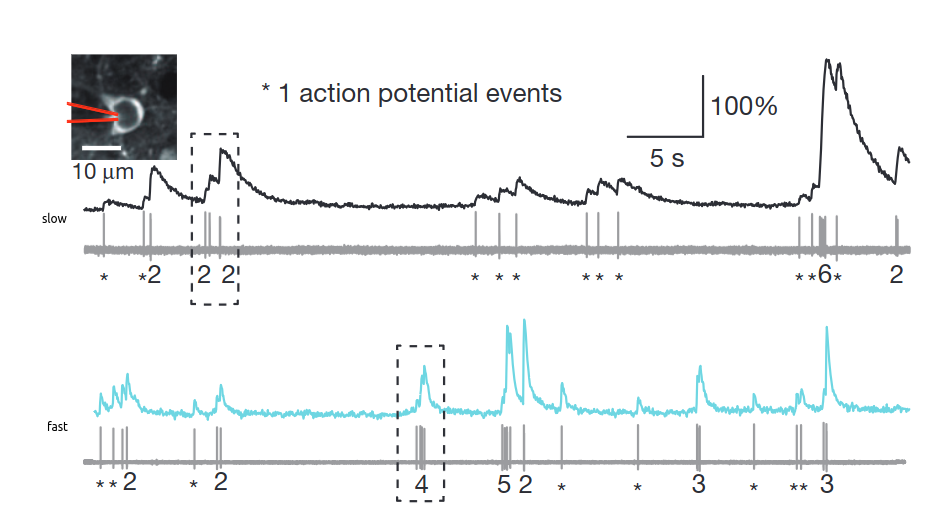

In this notebook you will work with 2 photon calcium recordings from mouse V1 and retina. For details see [Chen et al. 2013](https://www.nature.com/articles/nature12354) and [Theis et al. 2016](https://www.cell.com/neuron/pdf/S0896-6273(16)30073-3.pdf). Two-photon imaging is widely used to study computations in populations of neurons. 

In this exercise sheet we will study properties of different indicators and work on methods to infer spikes from calcium traces. All data is provided at a sampling rate of 100 Hz. For easier analysis, please resample it to 25 Hz. `scipy.signal.decimate` can help here, but note that it is only meant for continous signals. 

__Data__: Download the data file ```nds_cl_3_*.csv``` from ILIAS and save it in a subfolder ```../data/```. Note, some recordings were of shorter duration, hence their columns are padded. 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from __future__ import annotations

%matplotlib inline

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-05-08 19:49:29CEST

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

seaborn   : 0.13.2
scipy     : 1.15.2
pandas    : 2.2.3
numpy     : 2.2.5
matplotlib: 3.10.1

Watermark: 2.5.0



In [ ]:
plt.style.use("../../matplotlib_style.txt")

## Load data

In [3]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
print(f"[OGB] calcium: {ogb_calcium.shape}, spikes: {ogb_spikes.shape}")

# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)
print(f"[GCaMP] calcium: {gcamp_calcium.shape}, spikes: {gcamp_spikes.shape}")

# spike dataframe
ogb_spikes.head()

[OGB] calcium: (71986, 11), spikes: (71986, 11)
[GCaMP] calcium: (23973, 37), spikes: (23973, 37)


,0,1,2,3,4,5,6,7,8,9,10
0,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
1,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
2,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0
3,0,0,0.0,0.0,0,1,0,0.0,0,0.0,0
4,0,0,0.0,0.0,0,0,0,0.0,0,0.0,0


## Task 1: Visualization of calcium and spike recordings

We start again by plotting the raw data - calcium and spike traces in this case. One dataset has been recorded using the synthetic calcium indicator OGB-1 at population imaging zoom (~100 cells in a field of view) and the other one using the genetically encoded indicator GCamp6f zooming in on individual cells. Plot the traces of an example cell from each dataset to show how spikes and calcium signals are related. A good example cell for the OGB-dataset is cell 5. For the CGamp-dataset a good example is cell 6. Align the traces by eye (add a small offset to the plot) such that a valid comparison is possible and zoom in on a small segment of tens of seconds.

*Grading: 3 pts*

In [ ]:
"""
data info

the calcium signal is the relative change in flourescence intensity delF/F in a pixel defined as a cell

The signal was recorded with 35 frames/second
"""

In [43]:
# ogb dataset from Theis et al. 2016 Neuron
ogb_calcium = pd.read_csv("../data/nds_cl_3_ogb_calcium.csv", header=0)
ogb_spikes = pd.read_csv("../data/nds_cl_3_ogb_spikes.csv", header=0)
# gcamp dataset from Chen et al. 2013 Nature
gcamp_calcium = pd.read_csv("../data/nds_cl_3_gcamp2_calcium.csv", header=0)
gcamp_spikes = pd.read_csv("../data/nds_cl_3_gcamp2_spikes.csv", header=0)

# --------------------------------
# Resample and prepare data (1 pt)
# --------------------------------
ogb_spikes = ogb_spikes.groupby(ogb_spikes.index // 4).any().astype(int)
gcamp_spikes = gcamp_spikes.groupby(gcamp_spikes.index // 4).any().astype(int)

# 4-pole filter, as in Yaksi & Friedrich
ogb_calcium = pd.DataFrame(
    signal.decimate(ogb_calcium.fillna(0), q=4, n=4, axis=0),
    columns=ogb_calcium.columns,
)
gcamp_calcium = pd.DataFrame(
    signal.decimate(gcamp_calcium.fillna(0), q=4, n=4, axis=0),
    columns=gcamp_calcium.columns,
)
ogb_spikes.index = ogb_spikes.index / 25
gcamp_spikes.index = gcamp_spikes.index / 25

ogb_calcium.index = ogb_calcium.index / 25
gcamp_calcium.index = gcamp_calcium.index / 25


# TODO: add offset

Text(0.5, 0, 'Time[s]')

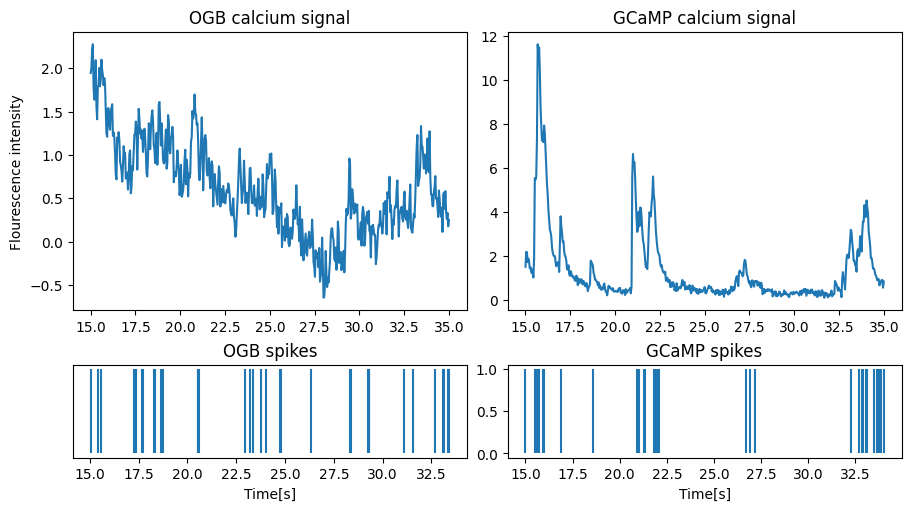

In [46]:
# --------------------
# Plot OGB data (1 pt)
# --------------------
# zoom in on 60s
start, stop = 15, 35

ogb, gcamp = ogb_spikes.loc[start:stop, "5"], gcamp_spikes.loc[start:stop, "6"]
ogb_c, gcamp_c = (
    ogb_calcium.loc[start:stop, "5"],
    gcamp_calcium.loc[start:stop, "6"],
)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2,
    2,
    figsize=(9, 5),
    height_ratios=[3, 1],
    layout="constrained",  # sharex="col"
)

ax1.set_title("OGB calcium signal")
ax1.set_ylabel("Flourescence intensity")
ax1.plot(ogb_c)

ax3.set_title("OGB spikes")
ax3.set_yticks([])
ax3.vlines(
    ogb[ogb == 1].index.values,
    ymin=0,
    ymax=1,
)
# ax3.set_xticklabels(ogb[ogb == 1].index.values)
ax3.set_xlabel("Time[s]")

# ----------------------
# Plot GCamp data (1 pt)
# ----------------------
ax2.set_title("GCaMP calcium signal")
ax2.plot(gcamp_c)

ax4.set_title("GCaMP spikes")
ax4.vlines(
    gcamp[gcamp == 1].index,
    ymin=0,
    ymax=1,
)
ax4.set_xlabel("Time[s]")

## Bonus Task (Optional): Calcium preprocessing

To improve the quality of the inferred spike trains, further preprocessing steps can undertaken. This includes filtering and smoothing of the calcium trace.

Implement a suitable filter and local averaging procedure as discussed in the lecture. Explain your choices and discuss how it helps!

_Grading: 1 BONUS point_

_BONUS Points do not count for this individual coding lab, but sum up to 5% of your **overall coding lab grade**. There are 4 BONUS points across all coding labs._

## Task 2: Simple deconvolution

It is clear from the above plots that the calcium events happen in relationship to the spikes. As a first simple algorithm implement a deconvolution approach like presented in the lecture in the function `deconv_ca`. Assume an exponential kernel where the decay constant depends on the indicator ($\tau_{OGB}= 0.5 s$, $\tau_{GCaMP}= 0.1 s$). Note there can be no negative rates! Plot the kernel as well as an example cell with true and deconvolved spike rates. Scale the signals such as to facilitate comparisons. You can use functions from `scipy` for this. Explain your results and your choice of kernel.

*Grading: 6 pts*


In [ ]:
def deconv_ca(ca: np.ndarray, tau: float, dt: float = 0.0) -> np.ndarray:
    """Compute the deconvolution of the calcium signal.

        Parameters
        ----------

        ca: np.array, (n_points,)
            Calcium trace

        tau: floatogb_deconv = deconv_ca(ogb_calcium.loc[:, "5"], tau_ogb, dt)
    gcamp_deconv = deconv_ca(gcamp_calcium.loc[:, "6"], tau_gc
            decay constant of conv kernel

        dt: float
            sampling interval.

        Return
        ------

        sp_hat: np.array
    """

    # --------------------------------------------
    # apply devonvolution to calcium signal (1 pt)
    # --------------------------------------------
    n_points = ca.size

    # length of kernel in [s]
    t_max = 10
    t = np.linspace(0, t_max, t_max * int(1 / dt))
    kernel = np.exp(-tau * t)
    sp_hat = signal.deconvolve(ca, kernel)[0]
    return sp_hat

In [ ]:
# -------------------------
# Plot the 2 kernels (1 pt)
# -------------------------
fig, ax = plt.subplots(figsize=(6, 5), layout="constrained")

# kernel lenght in [s]
t_max = 10

# sampling interval is 1/sampling_freq
dt = 1 / 25

# match sampling frequency of signal
t = np.linspace(0, t_max, t_max * int(1 / dt))


tau_ogb, tau_gcamp = 0.5, 0.1
kernel_OGB = np.exp(-tau_ogb * t)
kernel_GCaMP = np.exp(-tau_gcamp * t)
ax.plot(t, kernel_OGB, label="OGB kernel")
ax.plot(t, kernel_GCaMP, label="GCaMP kernel")
ax.legend()

In [ ]:
ogb_deconv = deconv_ca(ogb_calcium.loc[:, "5"], tau_ogb, dt)
gcamp_deconv = deconv_ca(gcamp_calcium.loc[:, "6"], tau_gcamp, dt)

In [ ]:
# spiketrains can't be negative
ogb_deconv[ogb_deconv < 0] = 0
gcamp_deconv[gcamp_deconv < 0] = 0

In [ ]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(10, 5),
)


# n_first = 5000
# n_last = 5250
n_first = 0
n_last = 10000

ax1.plot(ogb_calcium.loc[n_first:n_last, "5"].values)
ax1.plot(ogb_deconv[n_first:n_last])
ax2.plot(gcamp_calcium.loc[n_first:n_last, "6"].values)
ax2.plot(gcamp_deconv[n_first:n_last]);


### Questions (1 pt)
1) Explain how you constructed the kernels

Using a exponential decay function with the given time constants. Its important to make sure the kernels have the same sampling rate as the signal.

2) How do the indicators / kernels compare?

...


3) What are pros and cons of each indicator?

YOUR ANSWER HERE

In [ ]:
# ----------------------------------------------------------------------
# Compare true and deconvolved spikes rates for the OGB and GCamP cells.
# What do you notice? Why is that? (3 pts)
# ----------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamp Cell


## Task 3: Run more complex algorithm

As reviewed in the lecture, a number of more complex algorithms for inferring spikes from calcium traces have been developed. Run an implemented algorithm on the data and plot the result. There is a choice of algorithms available, for example:

* Vogelstein: [oopsi](https://github.com/liubenyuan/py-oopsi)
* Theis: [c2s](https://github.com/lucastheis/c2s)
* Friedrich: [OASIS](https://github.com/j-friedrich/OASIS)

*Grading: 3 pts*



In [ ]:
# run this cell to download the oopsi.py file and put it in the same folder as this notebook
!wget https://raw.githubusercontent.com/liubenyuan/py-oopsi/master/oopsi.py
import oopsi

In [ ]:
# ----------------------------------------------------------------------
# Apply one of the advanced algorithms to the OGB and GCamp Cells (1 pt)
# ----------------------------------------------------------------------


In [ ]:
# -------------------------------------------------------------------------------
# Plot the results for the OGB and GCamp Cells and describe the results (1+1 pts)
# -------------------------------------------------------------------------------

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# OGB Cell

fig, axs = plt.subplots(
    3, 1, figsize=(6, 4), height_ratios=[1, 1, 1], gridspec_kw=dict(hspace=0)
)

# GCamP Cell

## Task 4: Evaluation of algorithms

To formally evaluate the algorithms on the two datasets run the deconvolution algorithm and the more complex one on all cells and compute the correlation between true and inferred spike trains. `DataFrames` from the `pandas` package are a useful tool for aggregating data and later plotting it. Create a dataframe with columns

* algorithm
* correlation
* indicator

and enter each cell. Plot the results using `stripplot` and/or `boxplot` in the `seaborn` package. Note these functions provide useful options for formatting the
plots. See their documentation, i.e. `sns.boxplot?`.

*Grading: 5 pts*


First, evaluate on OGB data and create OGB dataframe. Then repeat for GCamp and combine the two dataframes.

In [ ]:
# ----------------------------------------------------------
# Evaluate the algorithms on the OGB and GCamp cells (2 pts)
# ----------------------------------------------------------

In [ ]:
# -------------------------------
# Construct the dataframe (1 pts)
# -------------------------------

Combine both dataframes. Plot the performance of each indicator and algorithm. You should only need a single plot for this.

In [ ]:
# ----------------------------------------------------------------------------
# Create Strip/Boxplot for both cells and algorithms Cell as described. (1 pt)
# Describe and explain the results briefly. (1 pt)
# ----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")
